### Install required packages

In [1]:
!pip install qiskit
!pip install qiskit-aer
!pip install qiskit-nature
!pip install pyscf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 979.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.6/308.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 MB 9.1 MB/s eta 0:00:00


### Ground state energy as a function of molecular distance

In [64]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
import numpy as np
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms.optimizers import SLSQP # this is the sequential least squares programming optimizer
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD


distance_array = np.linspace(0.05, 3.75, 50)
energy_vqe = []
energy_np = []
energy_hf = []

# calculate the ground state energy looping over the molecular distance
for distance in distance_array:
  # define the molecule
  driver = PySCFDriver(
      atom=f"H 0 0 0; H 0 0 {distance}",
      basis="sto3g",
      charge=0,
      spin=0,
      unit=DistanceUnit.ANGSTROM,
  )
  problem = driver.run()

  # define the initial ansatz variational circuit
  mapper = JordanWignerMapper()
  ansatz = UCCSD(
      problem.num_spatial_orbitals,
      problem.num_particles,
      mapper,
      initial_state=HartreeFock(
          problem.num_spatial_orbitals,
          problem.num_particles,
          mapper
      )
  )

  # define the solvers
  numpy_solver = NumPyMinimumEigensolver()
  vqe_solver = VQE(Estimator(), ansatz, SLSQP())

  # solve for the ground state energy
  calc_vqe = GroundStateEigensolver(mapper, vqe_solver)
  calc_np = GroundStateEigensolver(mapper, numpy_solver)

  res_vqe = calc_vqe.solve(problem)
  res_np = calc_np.solve(problem)

  energy_hf = np.append(energy_hf, res_vqe.hartree_fock_energy)
  energy_vqe = np.append(energy_vqe, res_vqe.total_energies)
  energy_np = np.append(energy_np, res_np.total_energies)

### Plotting the molecular energy vs. distance

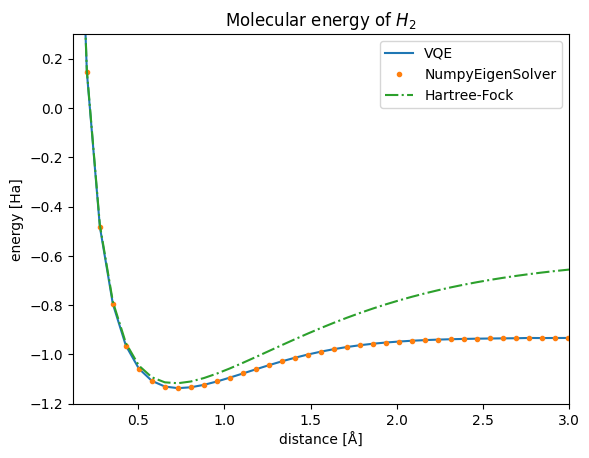

In [65]:
import matplotlib.pyplot as plt
plt.plot(distance_array, energy_vqe)
plt.plot(distance_array, energy_np, '.')
plt.plot(distance_array, energy_hf, '-.')
plt.xlim(0.12,3)
plt.ylim(-1.2,0.3)
plt.xlabel("distance [Å]")
plt.ylabel("energy [Ha]")
plt.title("Molecular energy of $H_2$")
plt.legend(["VQE", "NumpyEigenSolver", "Hartree-Fock"])
plt.show()

The VQE solution matches with the NumpyEigenSolver solution. The Hartree-Fock solution has the minimum at the same distance as VQE and NumpyEigenSolver, but it deviates at larger distances.  